# Part C: Implementation & Experiments

## C.1 Data Preprocessing

In this section, we load the Breast Cancer Wisconsin dataset, handle any missing data, standardize features, and split the data into training and test sets.

In [1]:
# Libraries import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import load_breast_cancer

In [23]:
# Load dataset and convert labels to binary (already 0/1 in sklearn)
data = load_breast_cancer()
X = data.data
y = data.target

# Check for missing values
print("Missing values:", np.isnan(X).any())

# Examine class distribution
print("Class distribution:", np.unique(y, return_counts=True))

# Split into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Missing values: False
Class distribution: (array([0, 1]), array([212, 357]))


In [24]:
# Display sample data
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
print("Dataset shape:", df.shape)
df.head(5)

Dataset shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## C.2 Algorithm Implementations

### C.2.1 Common Functions

Definition of sigmoid function and cost function with regularization options.

In [42]:
def sigmoid(z):
    # Clip extremely large/small values to prevent overflow/underflow
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def cost_function(X, y, theta, lambda_reg=0.01, reg_type='l2'):
    m = len(y)
    # Add intercept term
    X = np.c_[np.ones((m, 1)), X]
    Z = np.dot(X, theta)
    prediction = sigmoid(Z)
    
    # Avoid log(0) errors
    eps = 1e-6
    nll = -np.sum(y * np.log(prediction+eps) + (1 - y) * np.log(1 - prediction+eps))
    
    # Add regularization
    if reg_type == 'l2':
        reg_term = lambda_reg * np.sum(np.square(theta[1:]))    # Exclude theta[0]
    elif reg_type == 'l1':
        reg_term = lambda_reg * np.sum(np.abs(theta[1:]))   # Exclude theta[0]
    else:
        reg_term = 0
        
    cost = (1 / m) * (nll + reg_term)
    return cost

def predict(X, theta):
    X = np.c_[np.ones((X.shape[0], 1)), X]
    Z = np.dot(X, theta)
    prediction = sigmoid(Z)
    y_pred = np.where(prediction >= 0.5, 1, 0)
    return y_pred

### C.2.2 Particle Swarm Optimization (PSO)

PSO uses a swarm of particles representing potential solutions (β₀, β₁, ..., βₙ) that move through the parameter space.

In [27]:
# PSO Implementation
def run_pso(X_train, y_train, num_particles=100, n_iterations=75, 
           w=0.7, c1=1.5, c2=1.5, lambda_reg=0.01, reg_type='l2'):
    """
    Particle Swarm Optimization for logistic regression
    
    Parameters:
    X_train, y_train: Training data
    num_particles: Number of particles in the swarm
    n_iterations: Maximum number of iterations
    w: Inertia weight
    c1, c2: Cognitive and social constants
    lambda_reg: Regularization parameter
    reg_type: Type of regularization
    
    Returns:
    gbest_position: Best solution found
    history: Cost history over iterations
    """
    # Initialize particles and velocities
    dim = X_train.shape[1] + 1  # +1 for intercept
    particles = np.random.uniform(-1, 1, size=(num_particles, dim))
    velocities = np.random.uniform(-1, 1, size=(num_particles, dim))
    
    # Initialize personal and global best
    pbest_positions = particles.copy()
    pbest_values = np.array([cost_function(X_train, y_train, p, lambda_reg, reg_type) for p in particles])
    gbest_idx = np.argmin(pbest_values)
    gbest_position = pbest_positions[gbest_idx].copy()
    gbest_value = pbest_values[gbest_idx]
    
    # History for tracking progress
    history = [gbest_value]
    
    # Main PSO loop
    for iteration in range(n_iterations):
        for i in range(num_particles):
            # Update velocity
            r1, r2 = np.random.rand(1), np.random.rand(1)
            velocities[i] = (w * velocities[i] + 
                            r1 * c1 * (pbest_positions[i] - particles[i]) +
                            r2 * c2 * (gbest_position - particles[i]))
            
            # Update position
            particles[i] += velocities[i]
            
            # Evaluate new position
            current_value = cost_function(X_train, y_train, particles[i], lambda_reg, reg_type)
            
            # Update personal best
            if current_value < pbest_values[i]:
                pbest_positions[i] = particles[i].copy()
                pbest_values[i] = current_value
                
            # Update global best
            if current_value < gbest_value:
                gbest_value = current_value
                gbest_position = particles[i].copy()
                
        history.append(gbest_value)
        
    return gbest_position, history

In [28]:
# Run PSO
pso_solution, pso_history = run_pso(X_train, y_train, lambda_reg=0.01, reg_type='l2')

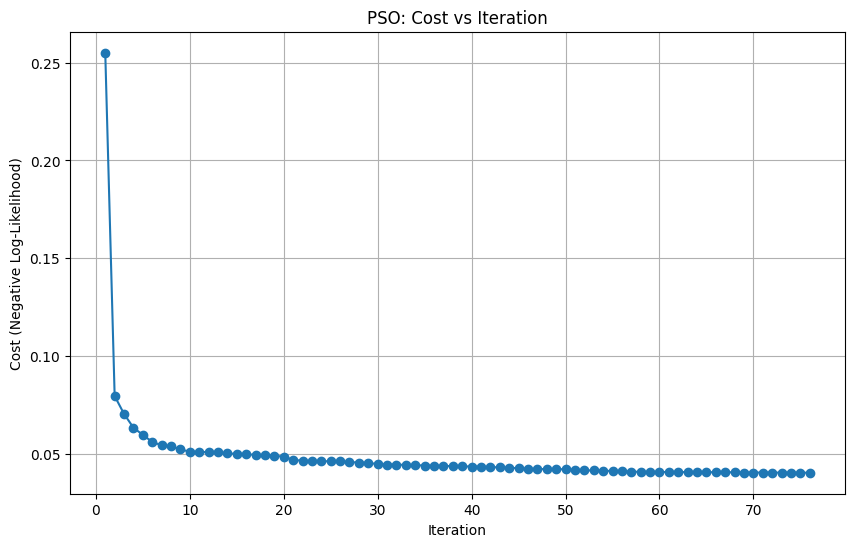

Accuracy PSO (test): 0.9766081871345029
Accuracy PSO (train): 0.9874371859296482

Confusion Matrix (test):
[[ 61   2]
 [  2 106]]

Classification Report (test):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



In [29]:
# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pso_history) + 1), pso_history, marker='o', linestyle='-')
plt.title('PSO: Cost vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost (Negative Log-Likelihood)')
plt.grid(True)
plt.show()

# Evaluate PSO performance
y_pred_test_pso = predict(X_test, pso_solution)
y_pred_train_pso = predict(X_train, pso_solution)
print("Accuracy PSO (test):", accuracy_score(y_test, y_pred_test_pso))
print("Accuracy PSO (train):", accuracy_score(y_train, y_pred_train_pso))
print("\nConfusion Matrix (test):")
print(confusion_matrix(y_test, y_pred_test_pso))
print("\nClassification Report (test):")
print(classification_report(y_test, y_pred_test_pso))

### C.2.3 Genetic Algorithm (GA)

GA represents solutions as chromosomes and uses selection, crossover, and mutation operators to evolve better solutions.

In [30]:
# GA Implementation
def run_ga(X_train, y_train, population_size=50, generations=100, 
          crossover_rate=0.8, mutation_rate=0.1, lambda_reg=0.01, reg_type='l2'):
    """
    Genetic Algorithm for logistic regression
    
    Parameters:
    X_train, y_train: Training data
    population_size: Number of individuals in the population
    generations: Maximum number of generations
    crossover_rate: Probability of crossover
    mutation_rate: Probability of mutation
    lambda_reg: Regularization parameter
    reg_type: Type of regularization
    
    Returns:
    best_individual: Best solution found
    history: Cost history over generations
    """
    # Initialize population
    dim = X_train.shape[1] + 1  # +1 for intercept
    population = np.random.uniform(-1, 1, (population_size, dim))
    history = []
    
    for gen in range(generations):
        # Evaluate fitness
        fitness_value = np.array([cost_function(X_train, y_train, p, lambda_reg, reg_type) for p in population])
        best_idx = np.argmin(fitness_value)
        best_individual = population[best_idx].copy()
        best_fitness = fitness_value[best_idx]
        history.append(best_fitness)
        
        # Tournament selection
        new_population = []
        for _ in range(population_size):
            idx1, idx2 = np.random.choice(population_size, size=2, replace=False)
            winner = population[idx1] if fitness_value[idx1] < fitness_value[idx2] else population[idx2]
            new_population.append(winner)
        new_population = np.array(new_population)
        
        # Crossover
        for i in range(0, population_size-1, 2):
            if np.random.rand() < crossover_rate:
                cross_point = np.random.randint(1, dim)
                temp = new_population[i, cross_point:].copy()
                new_population[i, cross_point:] = new_population[i+1, cross_point:]
                new_population[i+1, cross_point:] = temp
                
        # Mutation
        for i in range(population_size):
            if np.random.rand() < mutation_rate:
                mutation_vector = np.random.normal(0, 0.1, dim)
                new_population[i] += mutation_vector
                
        population = new_population.copy()
    
    # Final evaluation
    fitness_values = np.array([cost_function(X_train, y_train, p, lambda_reg, reg_type) for p in population])
    best_idx = np.argmin(fitness_values)
    best_individual = population[best_idx].copy()
    
    return best_individual, history

In [31]:
# Run GA
ga_solution, ga_history = run_ga(X_train, y_train, lambda_reg=0.01, reg_type='l2')

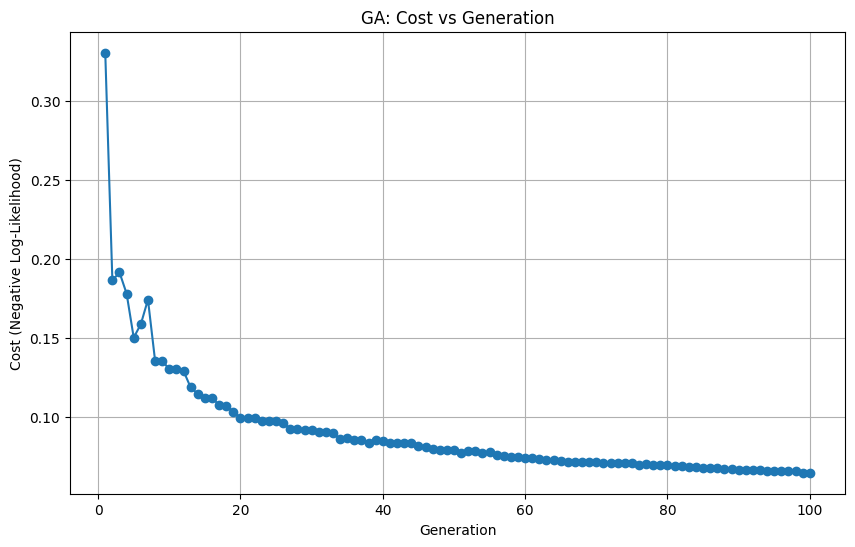

Accuracy GA (test): 0.9941520467836257
Accuracy GA (train): 0.9824120603015075

Confusion Matrix (test):
[[ 62   1]
 [  0 108]]

Classification Report (test):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.99      1.00      1.00       108

    accuracy                           0.99       171
   macro avg       1.00      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



In [32]:
# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ga_history) + 1), ga_history, marker='o', linestyle='-')
plt.title('GA: Cost vs Generation')
plt.xlabel('Generation')
plt.ylabel('Cost (Negative Log-Likelihood)')
plt.grid(True)
plt.show()

# Evaluate GA performance
y_pred_test_ga = predict(X_test, ga_solution)
y_pred_train_ga = predict(X_train, ga_solution)
print("Accuracy GA (test):", accuracy_score(y_test, y_pred_test_ga))
print("Accuracy GA (train):", accuracy_score(y_train, y_pred_train_ga))
print("\nConfusion Matrix (test):")
print(confusion_matrix(y_test, y_pred_test_ga))
print("\nClassification Report (test):")
print(classification_report(y_test, y_pred_test_ga))

### C.2.4 Simulated Annealing (SA)

SA uses a temperature parameter and the Metropolis criterion to accept or reject new solutions, allowing for exploration early and exploitation later.

In [33]:
# SA Implementation
def run_sa(X_train, y_train, init_temp=273, cooling_rate=0.95, n_iter=1000,
          step_size=0.1, lambda_reg=0.01, reg_type='l2'):
    """
    Simulated Annealing for logistic regression
    
    Parameters:
    X_train, y_train: Training data
    init_temp: Initial temperature
    cooling_rate: Rate at which temperature decreases
    n_iter: Maximum number of iterations
    step_size: Size of random steps
    lambda_reg: Regularization parameter
    reg_type: Type of regularization
    
    Returns:
    best_solution: Best solution found
    history: Cost history over iterations
    """
    # Initialize
    dim = X_train.shape[1] + 1  # +1 for intercept
    temp = init_temp
    current_sol = np.random.uniform(-1, 1, dim)
    current_cost = cost_function(X_train, y_train, current_sol, lambda_reg, reg_type)
    best_solution = current_sol.copy()
    best_cost = current_cost
    history = [best_cost]
    
    for i in range(n_iter):
        # Generate neighbor
        neighbour = current_sol + np.random.normal(0, step_size, dim)
        neighbour_cost = cost_function(X_train, y_train, neighbour, lambda_reg, reg_type)
        
        # Metropolis criterion
        delta = neighbour_cost - current_cost
        if delta < 0 or np.exp(-delta/temp) > np.random.rand():
            current_sol = neighbour.copy()
            current_cost = neighbour_cost
            
            # Update best solution
            if current_cost < best_cost:
                best_solution = current_sol.copy()
                best_cost = current_cost
                
        history.append(best_cost)
        
        # Cool down
        temp *= cooling_rate
        
    return best_solution, history

In [34]:
# Run SA
sa_solution, sa_history = run_sa(X_train, y_train, lambda_reg=0.01, reg_type='l2')

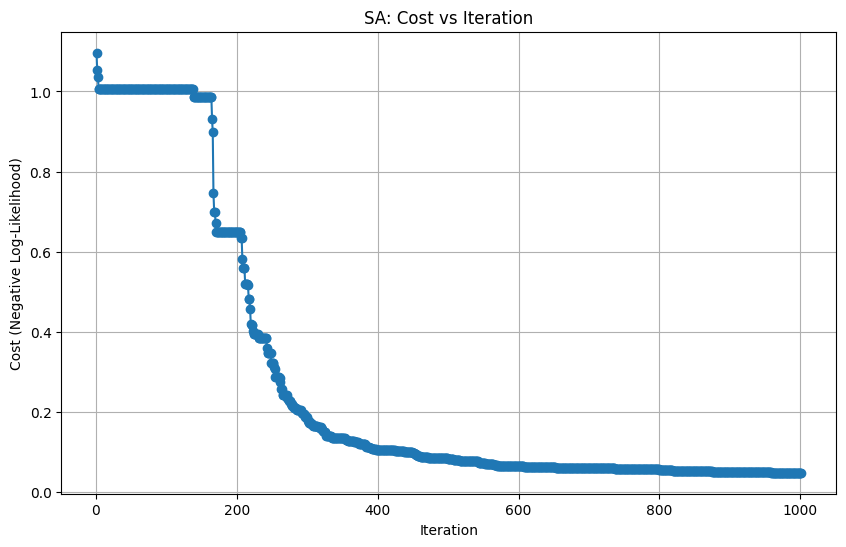

Accuracy SA (test): 0.9883040935672515
Accuracy SA (train): 0.9874371859296482

Confusion Matrix (test):
[[ 62   1]
 [  1 107]]

Classification Report (test):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        63
           1       0.99      0.99      0.99       108

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



In [35]:
# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sa_history) + 1), sa_history, marker='o', linestyle='-')
plt.title('SA: Cost vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost (Negative Log-Likelihood)')
plt.grid(True)
plt.show()

# Evaluate SA performance
y_pred_test_sa = predict(X_test, sa_solution)
y_pred_train_sa = predict(X_train, sa_solution)
print("Accuracy SA (test):", accuracy_score(y_test, y_pred_test_sa))
print("Accuracy SA (train):", accuracy_score(y_train, y_pred_train_sa))
print("\nConfusion Matrix (test):")
print(confusion_matrix(y_test, y_pred_test_sa))
print("\nClassification Report (test):")
print(classification_report(y_test, y_pred_test_sa))

## C.3 Objective Function and Regularization

In above example L2 regularization is used with λ=0.01. Let's now run an experiment with L1 regularization to compare the effects.

Accuracy with L1 regularization (test): 0.9824561403508771


L1 regularization sparsity: 0.0968 (9.7% coefficients near zero)
L2 regularization sparsity: 0.0645 (6.5% coefficients near zero)
L1 mean absolute coefficient: 1.4884
L2 mean absolute coefficient: 1.9379

Features with largest coefficient differences:
Feature 1: L1 = -3.3929, L2 = -1.5370
Feature 3: L1 = 0.2861, L2 = -2.2189
Feature 20: L1 = -0.1293, L2 = 2.3653
Feature 18: L1 = -0.0486, L2 = -2.6850
Feature 6: L1 = 0.9262, L2 = 5.7211


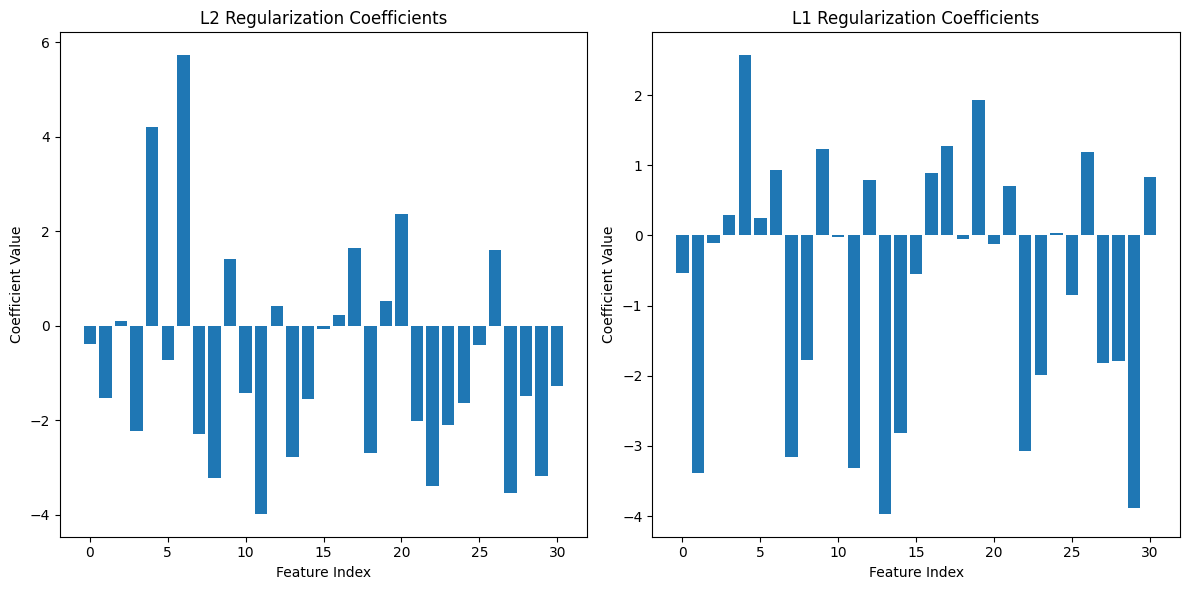

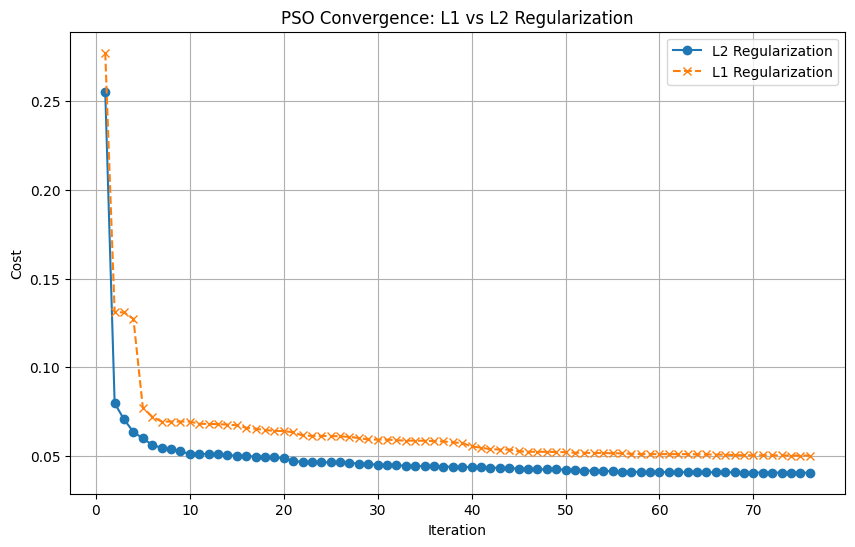

In [38]:
# Compare L1 and L2 regularization using PSO
pso_solution_l1, pso_history_l1 = run_pso(X_train, y_train, lambda_reg=0.01, reg_type='l1')

# Evaluate L1 regularization performance
y_pred_test_l1 = predict(X_test, pso_solution_l1)
print("Accuracy with L1 regularization (test):", accuracy_score(y_test, y_pred_test_l1))
print("\n")

# Compare L1 vs L2 coefficients
# Calculate sparsity (coefficients near zero) for both solutions
threshold = 0.1  # Define threshold for "close to zero"
l1_sparsity = np.sum(np.abs(pso_solution_l1) < threshold) / len(pso_solution_l1)
l2_sparsity = np.sum(np.abs(pso_solution) < threshold) / len(pso_solution)

# Compare coefficient magnitudes
l1_mean_abs = np.mean(np.abs(pso_solution_l1))
l2_mean_abs = np.mean(np.abs(pso_solution))

print(f"L1 regularization sparsity: {l1_sparsity:.4f} ({l1_sparsity*100:.1f}% coefficients near zero)")
print(f"L2 regularization sparsity: {l2_sparsity:.4f} ({l2_sparsity*100:.1f}% coefficients near zero)")
print(f"L1 mean absolute coefficient: {l1_mean_abs:.4f}")
print(f"L2 mean absolute coefficient: {l2_mean_abs:.4f}")

# Find coefficients with largest absolute difference
diff = np.abs(pso_solution_l1) - np.abs(pso_solution)
top_diff_idx = np.argsort(np.abs(diff))[-5:]  # Top 5 differences
print("\nFeatures with largest coefficient differences:")
for idx in top_diff_idx:
    print(f"Feature {idx}: L1 = {pso_solution_l1[idx]:.4f}, L2 = {pso_solution[idx]:.4f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(pso_solution)), pso_solution)
plt.title('L2 Regularization Coefficients')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')

plt.subplot(1, 2, 2)
plt.bar(range(len(pso_solution_l1)), pso_solution_l1)
plt.title('L1 Regularization Coefficients')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

# Compare convergence of L1 vs L2
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pso_history) + 1), pso_history, marker='o', linestyle='-', label='L2 Regularization')
plt.plot(range(1, len(pso_history_l1) + 1), pso_history_l1, marker='x', linestyle='--', label='L1 Regularization')
plt.title('PSO Convergence: L1 vs L2 Regularization')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

## C.4 Hyperparameter Tuning

Experimenting with different hyperparameters for each algorithm to see how they affect convergence and performance.

- Hyperparameter experimentation with PSO algorithm

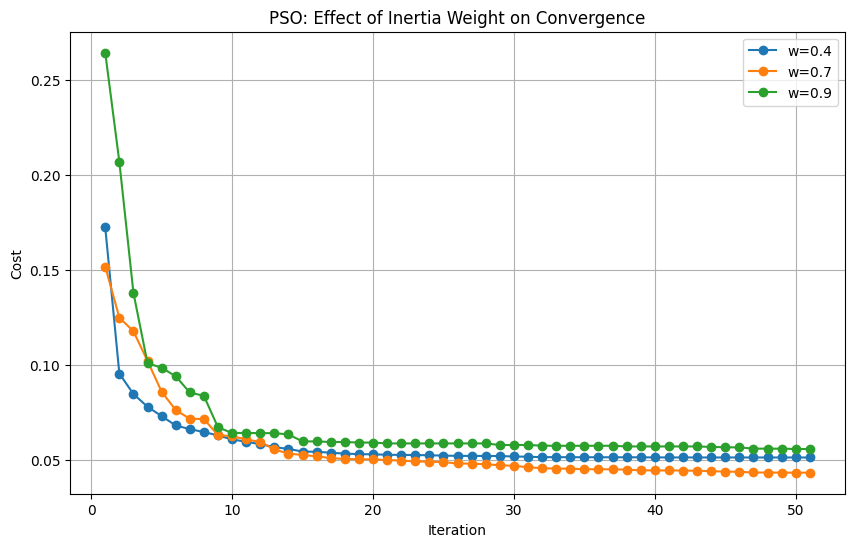

In [43]:
# PSO: Vary inertia weight (w)
w_values = [0.4, 0.7, 0.9]
pso_w_histories = []

for w in w_values:
    _, history = run_pso(X_train, y_train, w=w, n_iterations=50)
    pso_w_histories.append(history)

plt.figure(figsize=(10, 6))
for i, w in enumerate(w_values):
    plt.plot(range(1, len(pso_w_histories[i]) + 1), pso_w_histories[i], marker='o', linestyle='-', label=f'w={w}')
plt.title('PSO: Effect of Inertia Weight on Convergence')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

- Hyperparameter experimentation with GA algorithm

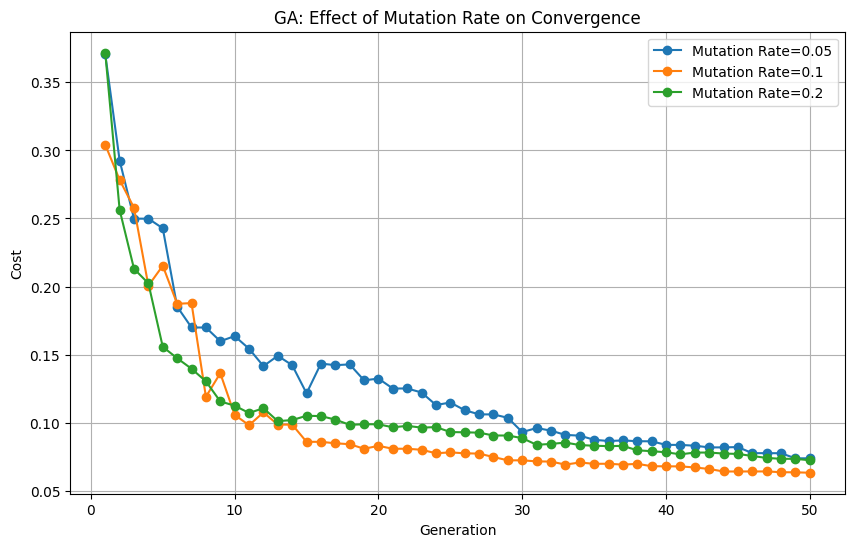

In [40]:
# GA: Vary mutation rate
mutation_rates = [0.05, 0.1, 0.2]
ga_mutation_histories = []

for rate in mutation_rates:
    _, history = run_ga(X_train, y_train, mutation_rate=rate, generations=50)
    ga_mutation_histories.append(history)

plt.figure(figsize=(10, 6))
for i, rate in enumerate(mutation_rates):
    plt.plot(range(1, len(ga_mutation_histories[i]) + 1), ga_mutation_histories[i], marker='o', linestyle='-', label=f'Mutation Rate={rate}')
plt.title('GA: Effect of Mutation Rate on Convergence')
plt.xlabel('Generation')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

- Hyperparameter experimentation with SA algorithm

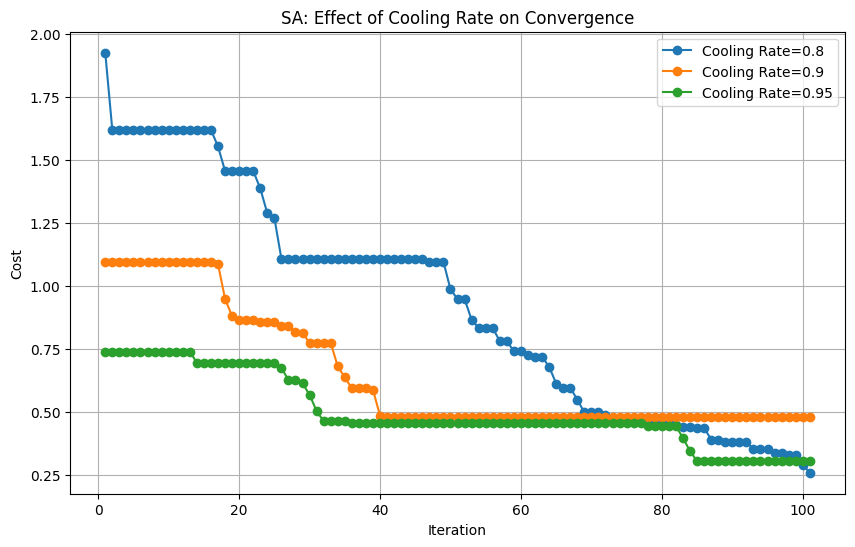

In [41]:
# SA: Vary cooling rate
cooling_rates = [0.8, 0.9, 0.95]
sa_cooling_histories = []
for rate in cooling_rates:
    _, history = run_sa(X_train, y_train, cooling_rate=rate, n_iter=100)
    sa_cooling_histories.append(history)
plt.figure(figsize=(10, 6))
for i, rate in enumerate(cooling_rates):
    plt.plot(range(1, len(sa_cooling_histories[i]) + 1), sa_cooling_histories[i], marker='o', linestyle='-', label=f'Cooling Rate={rate}')
plt.title('SA: Effect of Cooling Rate on Convergence')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

## C.5 Performance Metrics

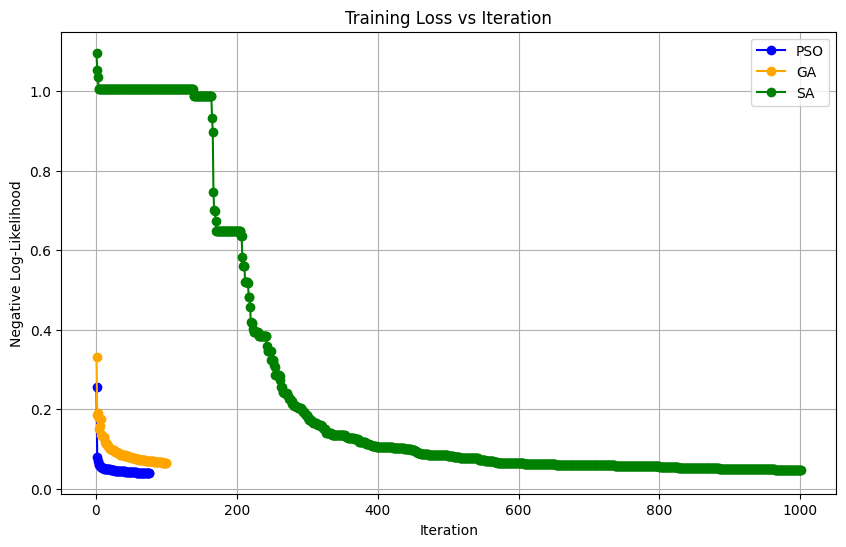

In [54]:
def predict(X, theta):
    X = np.c_[np.ones((X.shape[0], 1)), X]
    Z = np.dot(X, theta)
    prediction = sigmoid(Z)
    y_pred = np.where(prediction >= 0.5, 1, 0)
    return y_pred

# Track training loss convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pso_history) + 1), pso_history, 'o-', label='PSO', color='blue')
plt.plot(range(1, len(ga_history) + 1), ga_history, 'o-', label='GA', color='orange')
plt.plot(range(1, len(sa_history) + 1), sa_history, 'o-', label='SA', color='green')
plt.title('Training Loss vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Negative Log-Likelihood')
plt.legend()
plt.grid(True)
plt.show()


### PSO Performance

In [18]:
# Evaluate PSO
y_pred_test = predict(X_test, pso_solution)
y_pred_train = predict(X_train, pso_solution)
print("Accuracy PSO_test:", accuracy_score(y_test, y_pred_test))
print("Accuracy PSO_train:", accuracy_score(y_train, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Accuracy PSO_test: 0.9766081871345029
Accuracy PSO_train: 0.9874371859296482
Confusion Matrix:
[[ 61   2]
 [  2 106]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



### GA Performance

In [20]:
# Evaluate GA
y_pred_test = predict(X_test, ga_solution)
y_pred_train = predict(X_train, ga_solution)
print("Accuracy GA_test:", accuracy_score(y_test, y_pred_test))
print("Accuracy GA_train:", accuracy_score(y_train, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Accuracy GA_test: 0.9883040935672515
Accuracy GA_train: 0.9824120603015075
Confusion Matrix:
[[ 62   1]
 [  1 107]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        63
           1       0.99      0.99      0.99       108

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



### SA Performance

In [21]:
# Evaluate SA
y_pred_test = predict(X_test, sa_solution)
y_pred_train = predict(X_train, sa_solution)
print("Accuracy SA_test:", accuracy_score(y_test, y_pred_test))
print("Accuracy SA_train:", accuracy_score(y_train, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Accuracy SA_test: 0.9824561403508771
Accuracy SA_train: 0.9874371859296482
Confusion Matrix:
[[ 62   1]
 [  2 106]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



### Performance comparision

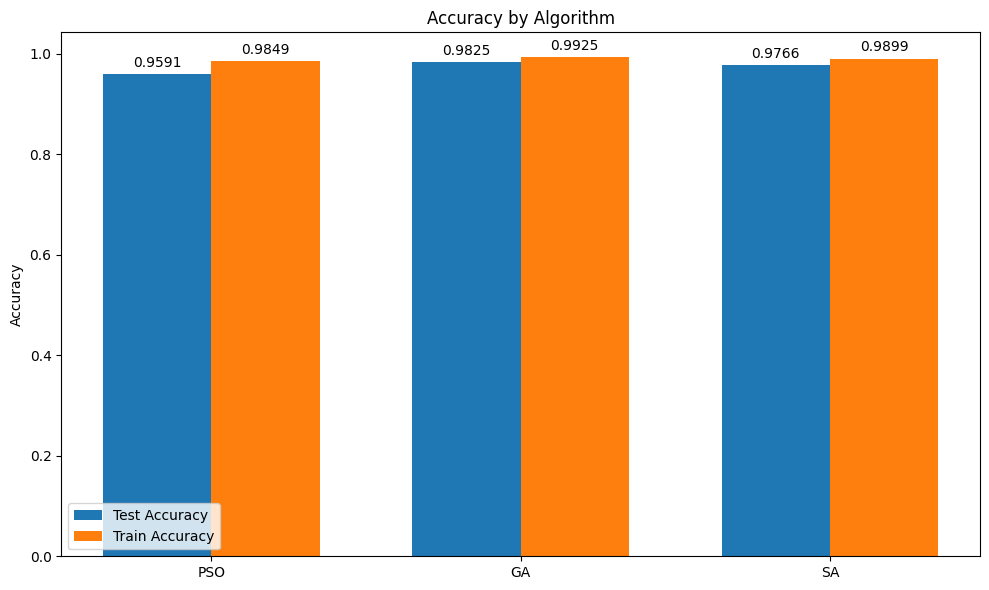

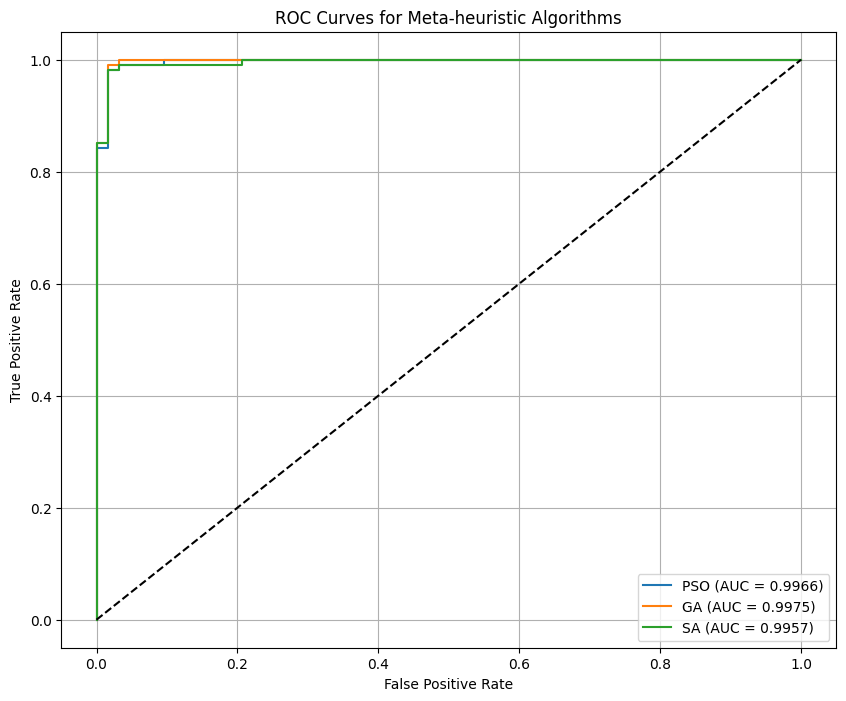

In [22]:
# Create a bar chart to compare test and train accuracies
algorithms = ['PSO', 'GA', 'SA']
test_accuracies = [0.9591, 0.9825, 0.9766]
train_accuracies = [0.9849, 0.9925, 0.9899]

x = np.arange(len(algorithms))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, test_accuracies, width, label='Test Accuracy')
rects2 = ax.bar(x + width/2, train_accuracies, width, label='Train Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# Calculate additional metrics like AUC
from sklearn.metrics import roc_curve, auc

# PSO ROC
pso_probs = sigmoid(np.dot(np.c_[np.ones((X_test.shape[0], 1)), X_test], pso_solution))
pso_fpr, pso_tpr, _ = roc_curve(y_test, pso_probs)
pso_auc = auc(pso_fpr, pso_tpr)

# GA ROC
ga_probs = sigmoid(np.dot(np.c_[np.ones((X_test.shape[0], 1)), X_test], ga_solution))
ga_fpr, ga_tpr, _ = roc_curve(y_test, ga_probs)
ga_auc = auc(ga_fpr, ga_tpr)

# SA ROC
sa_probs = sigmoid(np.dot(np.c_[np.ones((X_test.shape[0], 1)), X_test], sa_solution))
sa_fpr, sa_tpr, _ = roc_curve(y_test, sa_probs)
sa_auc = auc(sa_fpr, sa_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(pso_fpr, pso_tpr, label=f'PSO (AUC = {pso_auc:.4f})')
plt.plot(ga_fpr, ga_tpr, label=f'GA (AUC = {ga_auc:.4f})')
plt.plot(sa_fpr, sa_tpr, label=f'SA (AUC = {sa_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Meta-heuristic Algorithms')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()